# Deep Learning week - Day 4 - Predict Air Pollution

### Exercise objectives
- Prepare the data
- Further dig into Recurrent Neural Networks
- Stack multiple layers of RNNs

<hr>
<hr>

In this exercise, you will predict the pollution (measured as a number of particles) on the next day given a sequence of weather features, such as the temperature, the pression, etc.

In real-life applications, the data are not as well-prepared as in the previous exercises. For this reason, the first steps of the notebook correspond to the data preparation.

Then, given your new RNN ninja skills and the fact that the exercise is similar to previous challenges, less help is given as how to write a RNN. This can happen in real-life problems where you will always be able to get back to Le Wagon exercise to copy-paste what you have done to start working.


<hr><hr>

# Data

The data here corresponds to hourly measurements of the air pollution (feature: `pm2.5`, which is the concentration of 2.5 millimeter particles) that you will try to predict. Among the other related features, you have:
- TEMP: Temperature
- DEWP: Dew Point
- PRES: Pressure
- Ir: Cumulated hours of rain
- Iws: Cumulated wind speed
- Is: Cumulated hours of snow

❓ **Question** ❓ Load the data `data.txt` - use the first column as the index of a panda Dataframe.
Let's consider only the features presented above (pm2.5, TEMP, DEWP, PRES, Ir, Iws and Is)

In [5]:
import pandas as pd
df = pd.read_csv('data.txt', index_col='No')
features = ['pm2.5', 'DEWP', 'TEMP', 'PRES','Iws', 'Is', 'Ir']
df = df[features]

In [6]:
df.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir'], dtype='object')

❓ **Question** ❓ Plot the temporal progression of the different variables

array([<AxesSubplot:xlabel='No'>, <AxesSubplot:xlabel='No'>,
       <AxesSubplot:xlabel='No'>, <AxesSubplot:xlabel='No'>,
       <AxesSubplot:xlabel='No'>, <AxesSubplot:xlabel='No'>,
       <AxesSubplot:xlabel='No'>], dtype=object)

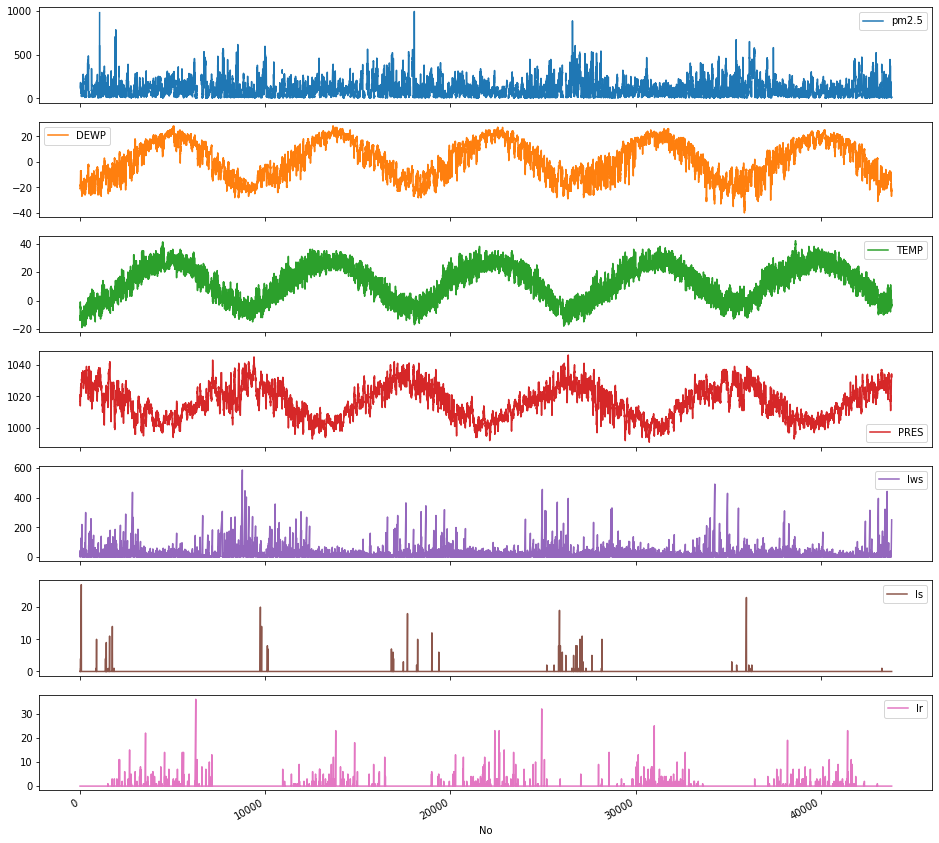

In [10]:
df.plot(subplots=True, figsize=(16,16))

❓ **Question** ❓ Let's normalize the variables `pm2.5` and `PRES` as their value can get very high. Just divide their values by a factor 1000.

In [11]:
df['pm2.5'] = df['pm2.5']/1000
df['PRES'] = df['PRES']/1000

In the previous exercises, we had multiple independent data sequences. Here, you notice that there is only one. And this is quite often the case. So how to deal with such data? In fact, this long sequence can be separated in a lot of short sequences that we will consider as independant. 

❓ **Question** ❓ Write a function that, given the initial dataframe, return a shorter dataframe sequence of length `length`. This shorter sequence should be selected at random.

In [454]:
from random import randrange
def subsample_sequence(df, length):
    start = randrange(0, df.shape[0]-length)
    end = start+length-1
    df_sample=df.loc[start : end, :]
    df_sample.reset_index(inplace=True)
    name = df_sample.columns[0]
    df_sample = df_sample.drop(columns = [name])
    return df_sample

df_subsample = subsample_sequence(df, length=3)
df_subsample

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
0,0.196,12,14.0,1.021,0.89,0,0
1,0.192,12,14.0,1.021,0.89,0,0
2,0.187,11,13.0,1.020,0.89,0,0


❓ **Question** ❓ Write a function that given a full dataframe, first subsample this dataset into a shorter sequence, and then splits the shorter dataframe into a training sequence and a value to predict.

Basically, if your sub-sampled dataframe is of size N, you will take the features during the N-1 first days as your variables `X`, and the value of the pollution at day N as your variable `y`.

❗ **Remark**❗ There are missing values in the dataframe. If the value to predict `y` is missing, the function should rerun. If there are missing values in the variables `X`, then it should be replaced by the mean values over the other selected hours. If all the other hours are missing, then they should all be replaced by the mean value of the dataframe.

❗ **Remark**❗ The outputs should be arrays or list, not a dataframe.

In [455]:
# def split_subsample_sequence(df, length):
#     df_subsample = subsample_sequence(df, length)
#     if pd.isnull(df_subsample.iloc[length-1,0]):
#         X_subsample, y_subsample = split_subsample_sequence(df, length)
#     else: 
#         if pd.isnull(df_subsample['TEMP'].mean()):
#             df_subsample['TEMP'].fillna(df['TEMP'].mean(), inplace=True)
#         else:
#             df_subsample['TEMP'].fillna(df_subsample['TEMP'].mean(), inplace=True)
#         X_subsample = df_subsample.loc[:length-2,:]
#         X_subsample = X_subsample.values
#         y_subsample = [df_subsample['pm2.5'][length-1]]
#     return X_subsample, y_subsample

# df_subsample = split_subsample_sequence(df, 10)

In [595]:
def split_subsample_sequence(df, length):
    df_subsample = subsample_sequence(df, length)
    if pd.isnull(df_subsample.iloc[length-1,0]):
        X_subsample, y_subsample = split_subsample_sequence(df, length)
    else:
        for col in df_subsample.columns:
            if pd.isnull(df_subsample[col].mean()):
                df_subsample[col].fillna(round(df[col].mean(),3), inplace=True)
            else:
                df_subsample[col].fillna(round(df_subsample[col].mean(),3), inplace=True)
        X_subsample = df_subsample.loc[:length-2,:]
        X_subsample = X_subsample.values
        y_subsample = [df_subsample['pm2.5'][length-1]]
    return X_subsample, y_subsample

df_subsample = split_subsample_sequence(df, 10)

In [599]:
split_subsample_sequence(df, 10)

(array([[  0.199, -20.   ,  -1.   ,   1.036,   0.89 ,   0.   ,   0.   ],
        [  0.168, -23.   ,   1.   ,   1.035,   1.78 ,   0.   ,   0.   ],
        [  0.093, -24.   ,   2.   ,   1.033,   2.67 ,   0.   ,   0.   ],
        [  0.08 , -23.   ,   3.   ,   1.033,   1.79 ,   0.   ,   0.   ],
        [  0.111, -22.   ,   3.   ,   1.033,   1.79 ,   0.   ,   0.   ],
        [  0.133, -19.   ,   3.   ,   1.032,   3.13 ,   0.   ,   0.   ],
        [  0.135, -17.   ,   1.   ,   1.033,   6.26 ,   0.   ,   0.   ],
        [  0.094, -16.   ,   0.   ,   1.033,   9.39 ,   0.   ,   0.   ],
        [  0.103, -17.   ,   0.   ,   1.033,  12.52 ,   0.   ,   0.   ]]),
 [0.092])

❓ **Question** ❓ Thanks to the previous function, write another function that generates an entire dataset $(X, y)$ of multiple subsamples, given an initial dataframe `df`, a number of desired sequences, and a `length` for each sequence.

In [619]:
def get_X_y(df, number_of_sequences, length):
    X = []
    y = []
    for _ in range(number_of_sequences):
        split = split_subsample_sequence(df, length)
        X.append(split[0])
        y.append(split[1])
    return np.array(X), np.array(y)

In [620]:
# def get_X_y(df, number_of_sequences, length):
#     X = []
#     y = []
#     for i in range(number_of_sequences):
#         xi, yi = split_subsample_sequence(df, length)
#         X.append(xi)
#         y.append(yi)
        
#     X = np.array(X)
#     y = np.array(y)
        
#     return X, y

❓ **Question** ❓ Generate a dataset $(X, y)$ with consists of 100 sequences, each of 20 observations - the value of the pollution at the 21-st day being the value to predict.

In [621]:
X, y = get_X_y(df, 100, 11)

In [622]:
y[2]

array([0.044])

In [623]:
X[2]

array([[6.500e-02, 1.900e+01, 2.500e+01, 1.008e+00, 8.630e+01, 0.000e+00,
        0.000e+00],
       [6.000e-02, 1.900e+01, 2.500e+01, 1.007e+00, 1.790e+00, 0.000e+00,
        0.000e+00],
       [6.500e-02, 1.900e+01, 2.600e+01, 1.007e+00, 3.580e+00, 0.000e+00,
        0.000e+00],
       [6.700e-02, 2.000e+01, 2.600e+01, 1.006e+00, 1.790e+00, 0.000e+00,
        0.000e+00],
       [6.100e-02, 2.000e+01, 2.600e+01, 1.006e+00, 5.810e+00, 0.000e+00,
        0.000e+00],
       [5.400e-02, 2.000e+01, 2.600e+01, 1.006e+00, 9.830e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 2.000e+01, 2.600e+01, 1.006e+00, 1.296e+01, 0.000e+00,
        0.000e+00],
       [4.800e-02, 2.000e+01, 2.500e+01, 1.005e+00, 1.609e+01, 0.000e+00,
        0.000e+00],
       [4.600e-02, 1.900e+01, 2.500e+01, 1.006e+00, 2.101e+01, 0.000e+00,
        0.000e+00],
       [5.500e-02, 1.900e+01, 2.400e+01, 1.005e+00, 2.503e+01, 0.000e+00,
        1.000e+00]])

In [624]:
dataset = get_X_y(df, 1000, 51)

❓ **Question** ❓ Check the shape of your inputs. `X` should be of size (100, 20, 7) ( => (sequences, length, number of features) )

In [625]:
dataset[0].shape

(1000, 50, 7)

❗ **IMPORTANT REMARK: POTENTIAL DATA LEAKAGE**❗ If you split this dataset (X, y) into a training and a test set, it is much likely that some data in the train set are in the test set. Especially, you will predict data in test that are input data in train.

To avoid this situation, you should _first_ separate your initial dataframe `df` into a training dataframe  and test dataframe.

❓ **Question** ❓ Separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training. And the last 20% in the test set.

In [626]:
index = int(0.8*df.shape[0])
index
df_train = df.iloc[:index, :]
df_test = df.iloc[index:, :]

In [627]:
df_test.reset_index(inplace=True)

❓ **Question** ❓ Now, you can generate (X_train, y_train) from df_train and (X_test, y_test) from df_test.
The training test should correspond to 1000 sequences, each of size 50 (+ the time to predict). The test set should correspond to 200 sequences

In [628]:
df_test.drop(columns = ['No'], inplace=True)

/home/florent/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [629]:
X_train, y_train =  get_X_y(df_train, 1000, 51) 
X_test, y_test =  get_X_y(df_test, 200, 51) 

❓ **Question** ❓ Initialize a model the way you want and compile it within the `init_model` function. _TRY_ to do it, before looking at the previous exercise.
Start here with a simple `LSTM`.

In [641]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

def init_model():
    
    model = Sequential()
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(12, activation='relu'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer='rmsprop', 
                  metrics=['mae'])
    
    return model

❓ **Question** ❓ Fit your model and evaluate it on the test data

In [642]:
model = init_model()

In [643]:
model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=1000, 
            batch_size=32,
            callbacks=[es])

Epoch 1/1000
25/25 [==============================] - 1s 53ms/step - loss: 0.0181 - mae: 0.1021 - val_loss: 0.0159 - val_mae: 0.0890
Epoch 2/1000
25/25 [==============================] - 1s 27ms/step - loss: 0.0089 - mae: 0.0705 - val_loss: 0.0122 - val_mae: 0.0752
Epoch 3/1000
25/25 [==============================] - 1s 22ms/step - loss: 0.0069 - mae: 0.0624 - val_loss: 0.0114 - val_mae: 0.0677
Epoch 4/1000
25/25 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0579 - val_loss: 0.0103 - val_mae: 0.0663
Epoch 5/1000
25/25 [==============================] - 1s 20ms/step - loss: 0.0055 - mae: 0.0562 - val_loss: 0.0102 - val_mae: 0.0642
Epoch 6/1000
25/25 [==============================] - 1s 21ms/step - loss: 0.0051 - mae: 0.0530 - val_loss: 0.0096 - val_mae: 0.0629
Epoch 7/1000
25/25 [==============================] - 1s 20ms/step - loss: 0.0049 - mae: 0.0526 - val_loss: 0.0096 - val_mae: 0.0620
Epoch 8/1000
25/25 [==============================] - 1s 20ms/step - 

25/25 [==============================] - 1s 21ms/step - loss: 0.0015 - mae: 0.0285 - val_loss: 0.0038 - val_mae: 0.0404
Epoch 63/1000
25/25 [==============================] - 1s 21ms/step - loss: 0.0015 - mae: 0.0283 - val_loss: 0.0038 - val_mae: 0.0391
Epoch 64/1000
25/25 [==============================] - 1s 21ms/step - loss: 0.0014 - mae: 0.0266 - val_loss: 0.0038 - val_mae: 0.0403
Epoch 65/1000
25/25 [==============================] - 1s 21ms/step - loss: 0.0014 - mae: 0.0270 - val_loss: 0.0040 - val_mae: 0.0433
Epoch 66/1000
25/25 [==============================] - 1s 21ms/step - loss: 0.0015 - mae: 0.0279 - val_loss: 0.0037 - val_mae: 0.0414
Epoch 67/1000
25/25 [==============================] - 1s 22ms/step - loss: 0.0013 - mae: 0.0261 - val_loss: 0.0036 - val_mae: 0.0393
Epoch 68/1000
25/25 [==============================] - 1s 21ms/step - loss: 0.0013 - mae: 0.0270 - val_loss: 0.0039 - val_mae: 0.0418
Epoch 69/1000
25/25 [==============================] - 1s 22ms/step - loss: 

❓ **Question** ❓ Compare your prediction to a benchmark prediction

In [644]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 6ms/step - loss: 0.0024 - mae: 0.0347


[0.0024246112443506718, 0.03467689827084541]

In [645]:
y_pred = X_test[:, -1, 0]
y_pred.shape

(200,)

In [646]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.012555

In [647]:
y_pred = X_test[:, -1, 0]
mae = sum(abs(y_test[0] - y_pred)) / y_test.shape[0]
mae

0.07225999999999999

In [638]:
model.predict(X_test)[:10]

array([[0.05307124],
       [0.16690081],
       [0.07838294],
       [0.05414558],
       [0.10836218],
       [0.01988208],
       [0.07814796],
       [0.32645684],
       [0.16991784],
       [0.09331595]], dtype=float32)

In [639]:
y_test[:10]

array([[0.053],
       [0.184],
       [0.018],
       [0.06 ],
       [0.015],
       [0.015],
       [0.019],
       [0.346],
       [0.147],
       [0.094]])

In [640]:
X_test[:, -1, 0][:10]

array([0.057, 0.182, 0.007, 0.038, 0.031, 0.006, 0.038, 0.327, 0.152,
       0.087])

# Stack RNN layers

❓ **Question** ❓ Now that you know how to write a recurrent architecture, let's see how to stack one.
If you want to stack multiple RNN, LSTM, GRU layers, it is very easy. Do it as if they were Dense (or any other) layers.

But don't forget: All RNN (**EXCEPT** the last one) should have the `return_sequences` set to True so that the entire sequence of predictions of a given layer is given to the next layer. Otherwise, you will only give the last prediction to the next layer.

In [ ]:
def init_model_2():
    ### YOUR CODE HERE 

❓ **Question** ❓ Evaluate your new model to the previous prediction and to the baseline model

In [ ]:
### YOUR CODE HERE

❓ **Question** ❓ Now, let's see how the performance changes depending on the number of seen days we used to sample our initial splits (50 days in the previous example).

For different values of temporal sequence lengths, resplit your data, run your model and evaluate its performance (do not forget to reinitialize your model between each run)

In [ ]:
### YOUR CODE HERE